In [2]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

Sun Apr 28 20:57:05 KST 2024


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [4]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [4]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


In [5]:
# Let's look at the tail end of this dataframe
df_all.tail()

,home_team,away_team,home_score,away_score,year
55,Italy,France,18,40,2017
56,England,Scotland,61,21,2017
57,Scotland,Italy,29,0,2017
58,France,Wales,20,18,2017
59,Ireland,England,13,9,2017


In [5]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])

Text(0, 0.5, 'Average (abs) point difference')

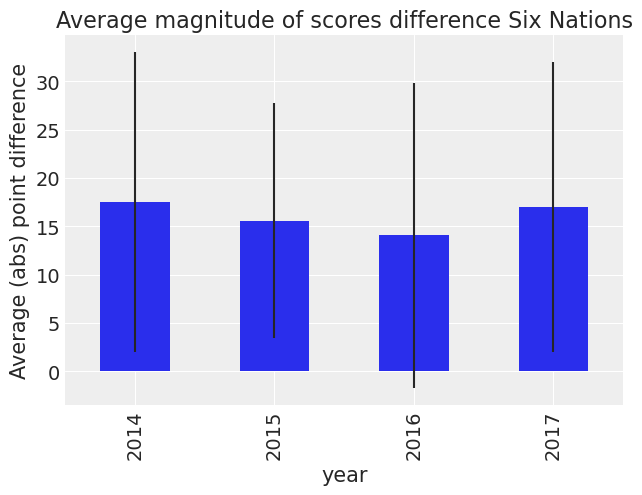

In [7]:
(df_all.groupby('year')['difference']
 .mean()
 .plot(
     kind = "bar"
     , title = "Average magnitude of scores difference Six Nations"
     , yerr = df_all.groupby('year')['difference'].std()
 )
 .set_ylabel("Average (abs) point difference")
 )

In [8]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]
df_all.pivot_table("difference_non_abs", "home_team", "year")


year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


Text(0, 0.5, 'Score difference Home team and away team')

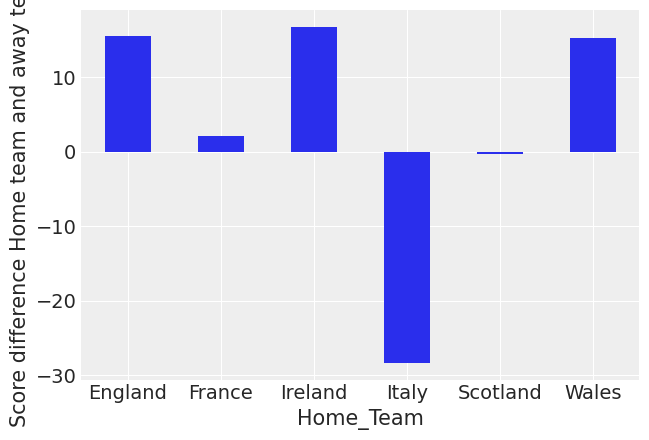

In [9]:
(df_all.pivot_table("difference_non_abs", "home_team")
 .rename_axis("Home_Team")
 .plot(kind = "bar", rot = 0, legend = False)
 .set_ylabel("Score difference Home team and away team")
 )


In [10]:
df_all.pivot_table("difference_non_abs", "away_team")

,difference_non_abs
away_team,
England,-10.2
France,2.8
Ireland,-6.8
Italy,24.2
Scotland,13.2
Wales,-2.1


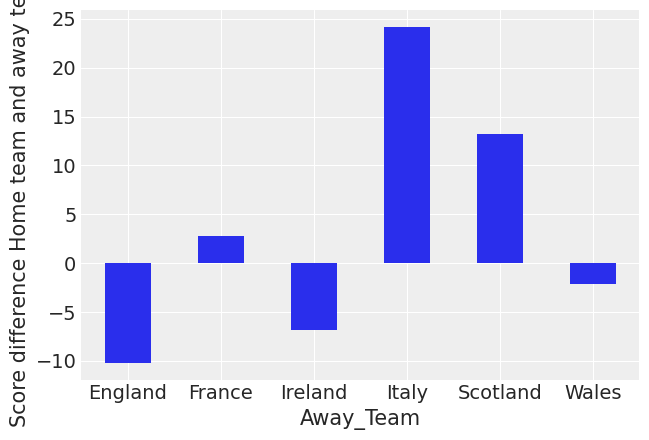

In [11]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

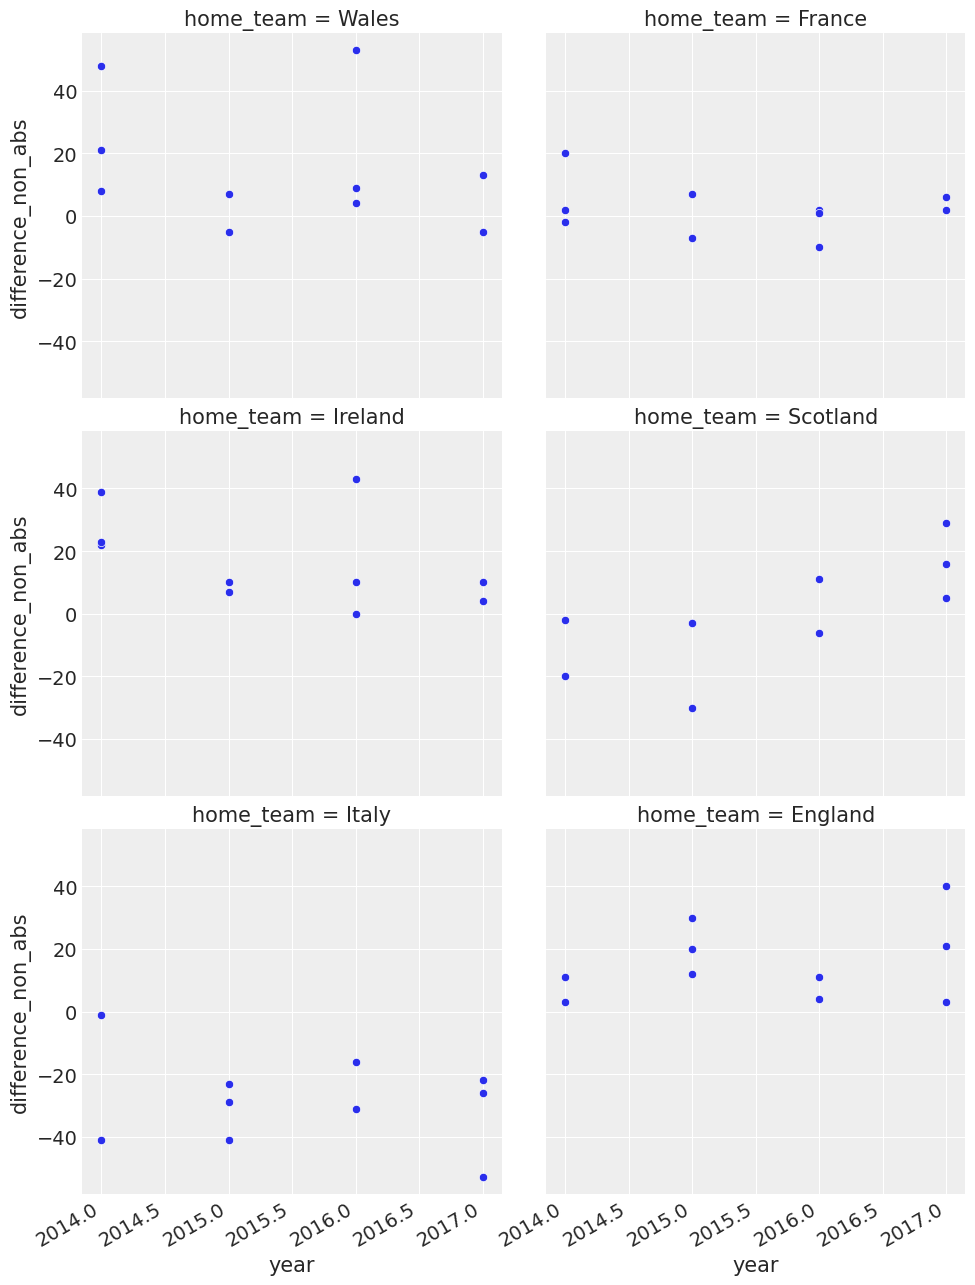

In [12]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=5)
g.map(sns.scatterplot, "year", "difference_non_abs")
g.figure.autofmt_xdate()

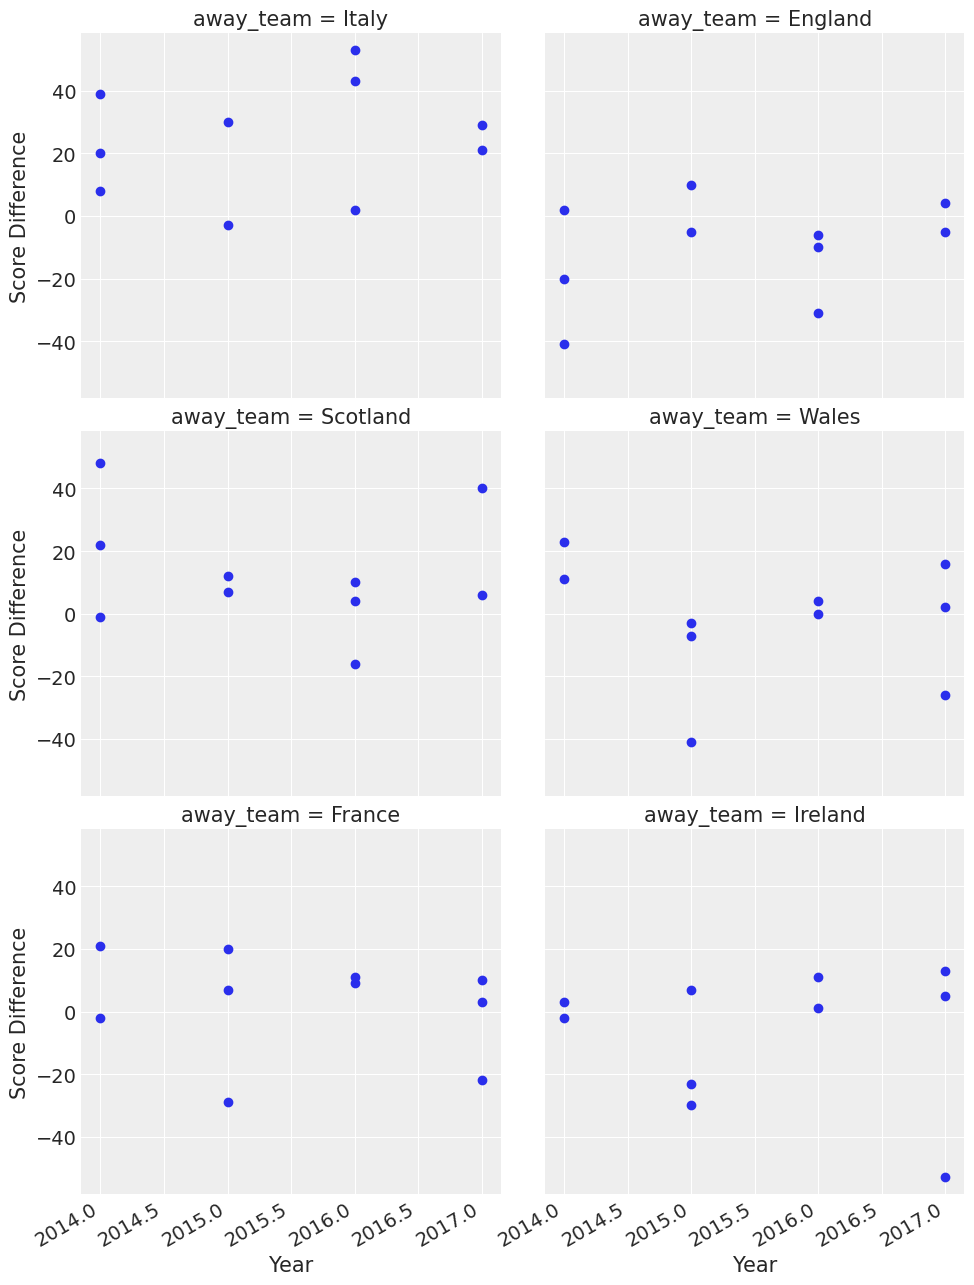

In [13]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, height=5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")
g.figure.autofmt_xdate()

In [7]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [14]:
with pm.Model(coords=coords) as model:
    # constant data: 데이터의 각 행(60)이 match 차원이  됨 / 데이터를 차원으로 펼침
    home_team = pm.ConstantData("home_team", home_idx, dims="match") 
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    # global model parameters
    intercept = pm.Normal("intercept", mu=3, sigma=1)   # 득점 강도의 기준점
    home = pm.Normal("home", mu=0, sigma=1)             # 홈 팀의 이점
    sd_att = pm.HalfNormal("sd_att", sigma=2)           # 공격 능력의 표준편차
    sd_def = pm.HalfNormal("sd_def", sigma=2)           # 수비 능력의 표준편차

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team") # 각 팀의 공격 능력
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team") # 각 팀의 수비 능력
    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team") # 중심화(정확히 0)된 공격 능력
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team") # 중심화(정확히 0)된 수비 능력
    
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx]) 
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])
    # 사후 추론 과정에서 분석하고자 하는 변량이 아니라고 판단하여 pm.Deterministic으로 감싸지 않았으나, 필요시 정의할 수 있다.
        # home_theta = pm.Deterministic('home_theta', pt.exp(intercept + home + atts[home_idx] + defs[away_idx]), dim = "match")
        # away_theta = pm.Deterministic('away_theta', pt.exp(intercept + atts[away_idx] + defs[home_idx]), dim = "match")

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1500, cores=4)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 7 seconds.


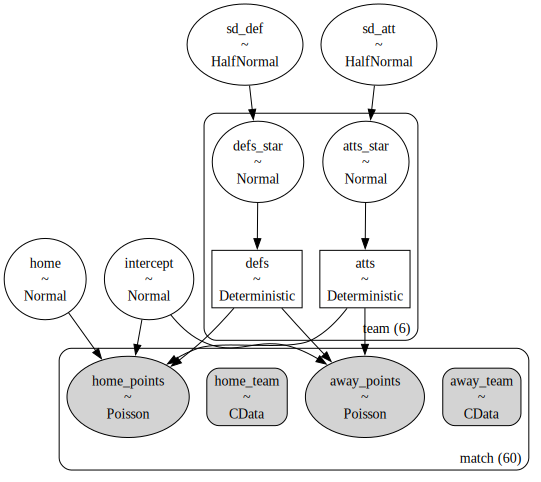

In [18]:
pm.model_to_graphviz(model)

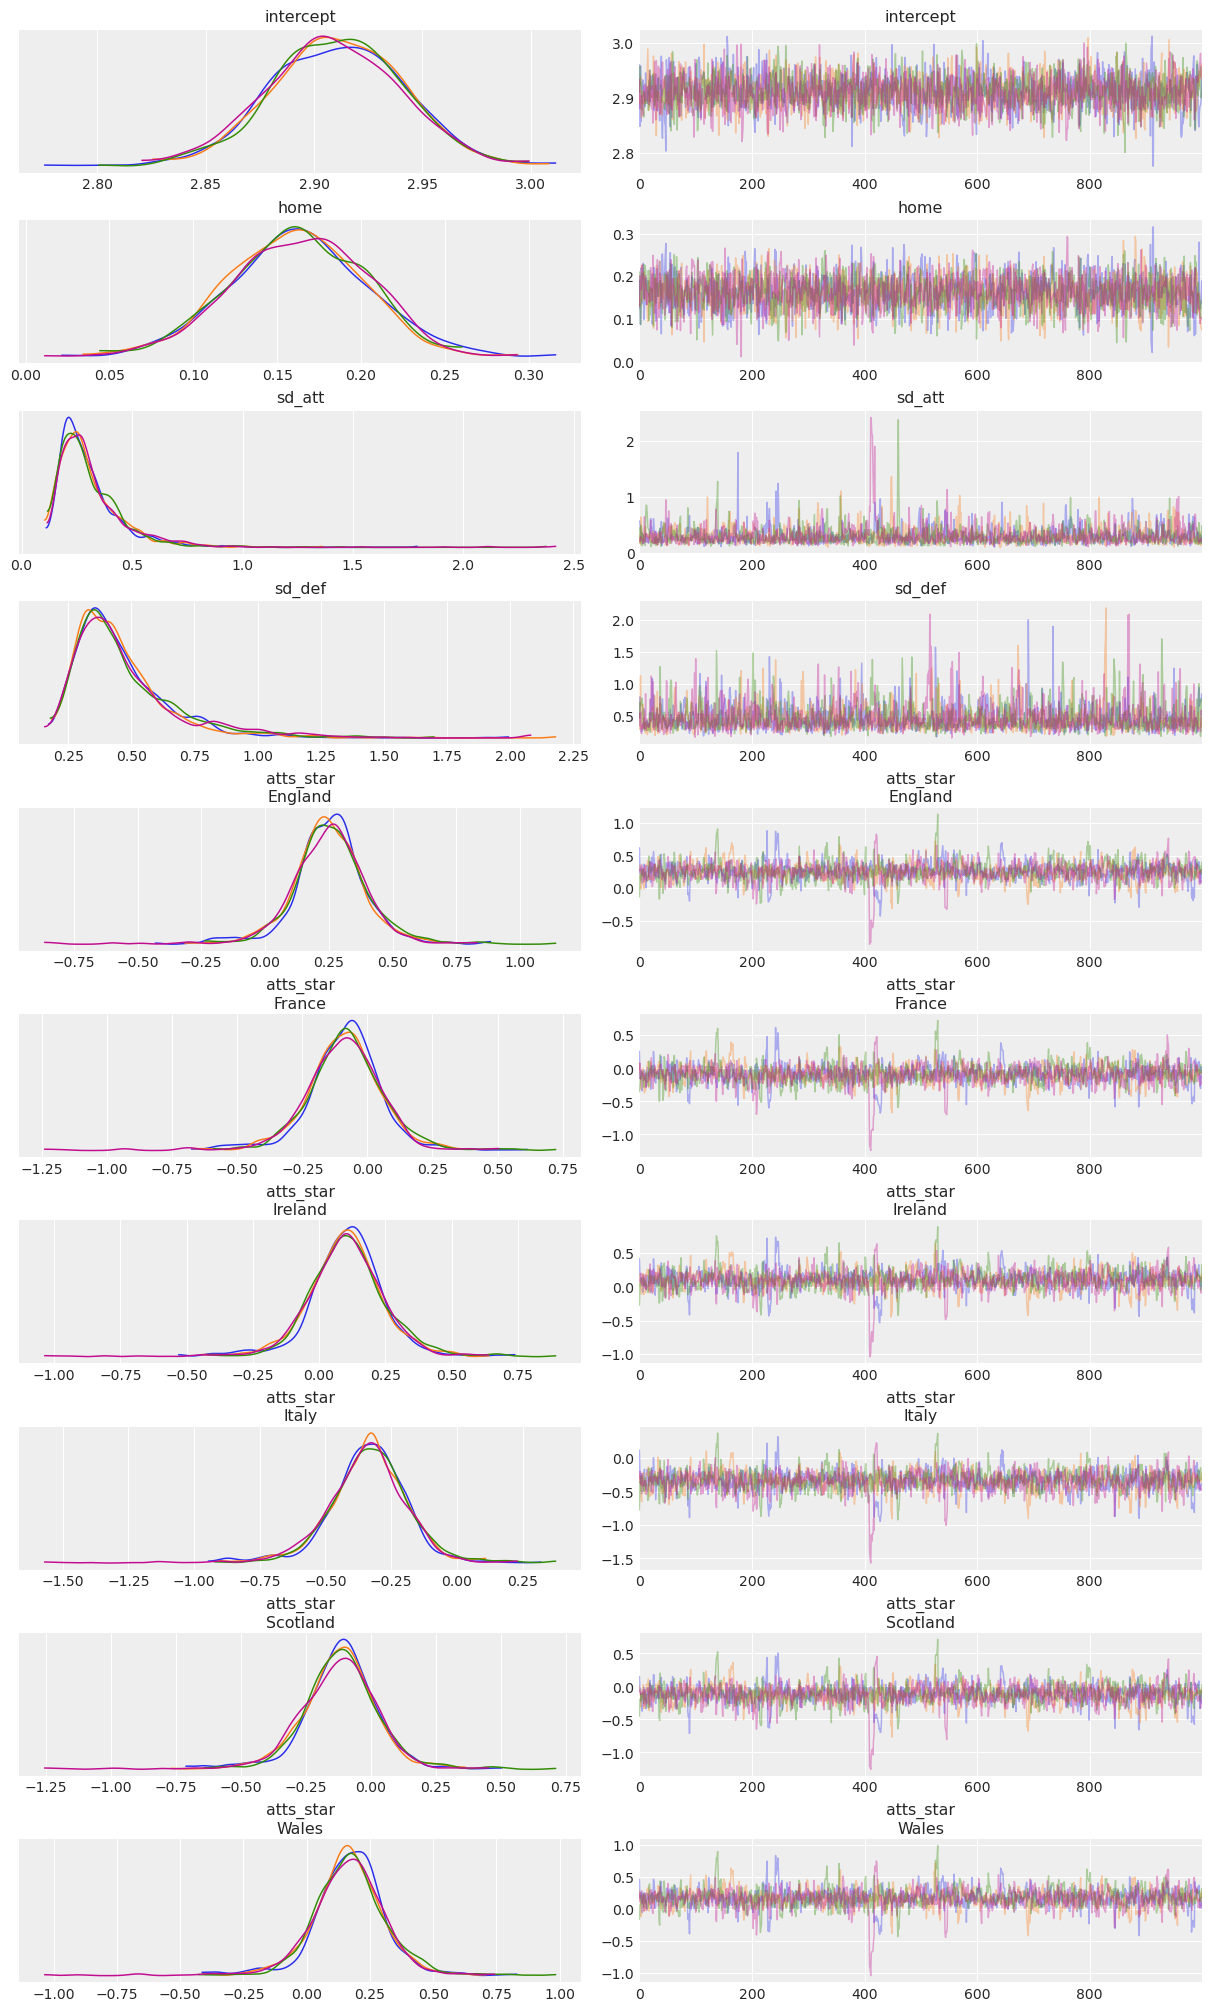

In [16]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_att", "sd_def", "atts_star"], compact=False);

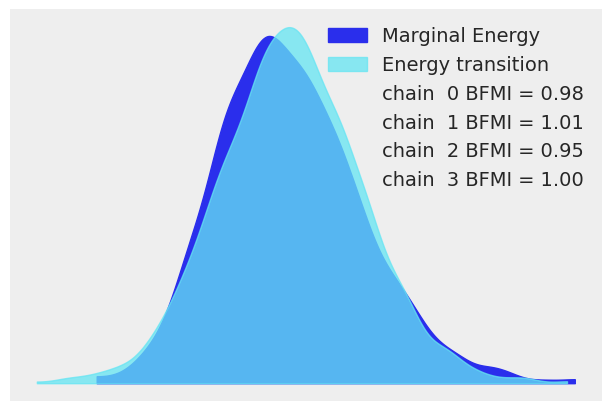

In [17]:
az.plot_energy(trace, figsize=(6, 4));

In [22]:
coords

{'team': Index(['England', 'France', 'Ireland', 'Italy', 'Scotland', 'Wales'], dtype='object')}

In [24]:
with pm.Model(coords = coords) as model:
    home_team = pm.ConstantData("home_team", home_idx, dims = "match")
    away_team = pm.ConstantData("away_team", away_idx, dims = "match")

    intercept = pm.Normal("intercept", mu = 3, sigma = 1)
    home = pm.Normal("home", mu = 0, sigma =1)
    sd_att = pm.HalfNormal("sd_att", sigma =2)
    sd_def = pm.HalfNormal("sd_def", sigma =2)

    atts_star = pm.Normal("atts_star", mu = 0, sigma = sd_att, dims = "team")
    defs_star = pm.Normal("defs_star", mu = 0, sigma = sd_def, dims = "team")
    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims = "team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims = "team")

    home_theta = pm.Deterministic("home_theta", pt.exp(intercept + home + atts[home_idx] + defs[away_idx]), dims = "match")
    away_theta = pm.Deterministic("away_theta", pt.exp(intercept + atts[away_idx] + defs[home_idx]), dims = "match")

    home_points = pm.Poisson("home_points"
                             , mu = home_theta
                             , observed = df_all["home_score"]
                             , dims = "match")

    away_points = pm.Poisson("away_points"
                             , mu = away_theta
                             , observed = df_all["away_score"]
                             , dims = "match")
    
    trace = pm.sample(1000, tune = 1500, cores = 4)
    # tune: 사후 분포의 샘플링을 시작하기 전에 최적화를 위해 사용되는 단계의 수
    # cores: 병렬 처리에 사용할 코어의 수

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, home, sd_att, sd_def, atts_star, defs_star]


Output()

In [ ]:
pm.model_to_graphviz(model)

In [18]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atts[England],0.001,0.000,4757.0,3058.0,1.00
atts[France],0.001,0.000,4932.0,2967.0,1.00
atts[Ireland],0.001,0.000,5178.0,3162.0,1.00
atts[Italy],0.001,0.001,4581.0,3045.0,1.00
atts[Scotland],0.001,0.000,5107.0,3271.0,1.00
atts[Wales],0.001,0.000,5378.0,3418.0,1.00
atts_star[England],0.008,0.007,1053.0,703.0,1.00
atts_star[France],0.008,0.008,1080.0,714.0,1.00
atts_star[Ireland],0.008,0.007,1079.0,666.0,1.00
atts_star[Italy],0.008,0.007,1113.0,707.0,1.00


In [19]:
trace_hdi = az.hdi(trace)
trace_hdi["atts"]

<xarray.DataArray 'atts' (team: 6, hdi: 2)> Size: 96B
array([[ 0.17926879,  0.32907237],
       [-0.16357845,  0.00094106],
       [ 0.02265002,  0.18113089],
       [-0.44068397, -0.22996532],
       [-0.20269408, -0.03036947],
       [ 0.0924334 ,  0.24813653]])
Coordinates:
  * team     (team) <U8 192B 'England' 'France' 'Ireland' ... 'Scotland' 'Wales'
  * hdi      (hdi) <U6 48B 'lower' 'higher'

In [20]:
trace.posterior["atts"].median(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)> Size: 48B
array([ 0.25682723, -0.08436102,  0.10913305, -0.33564434, -0.11600622,
        0.17275738])
Coordinates:
  * team     (team) <U8 192B 'England' 'France' 'Ireland' ... 'Scotland' 'Wales'

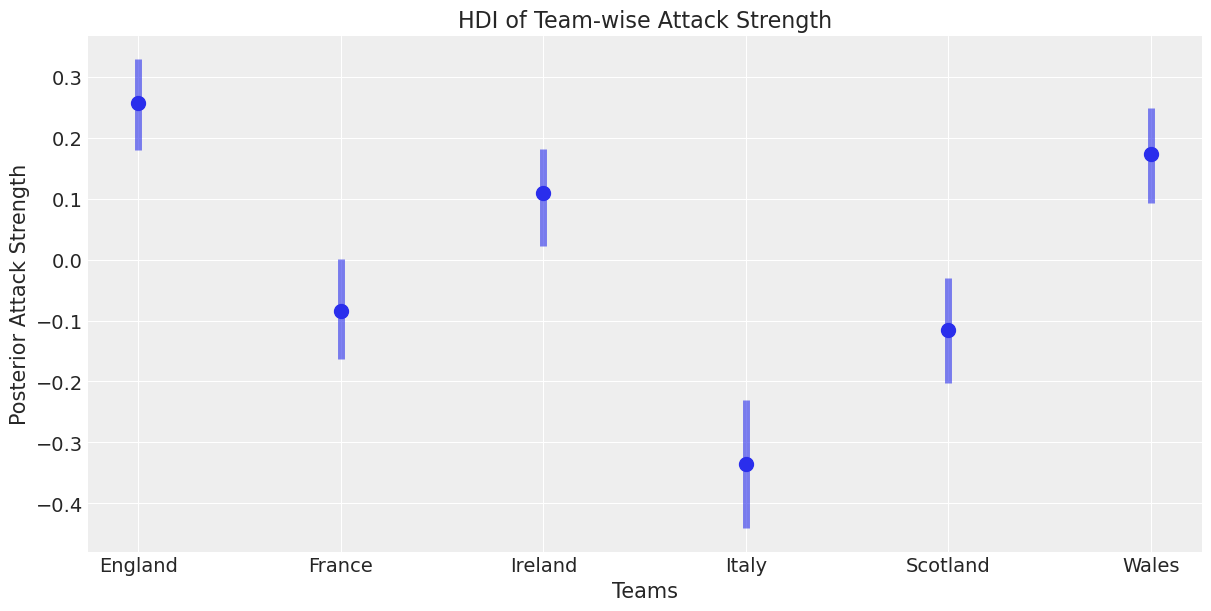

In [21]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength");

In [22]:
# subclass arviz labeller to omit the variable name
class TeamLabeller(az.labels.BaseLabeller):
    def make_label_flat(self, var_name, sel, isel):
        sel_str = self.sel_to_str(sel, isel)
        return sel_str

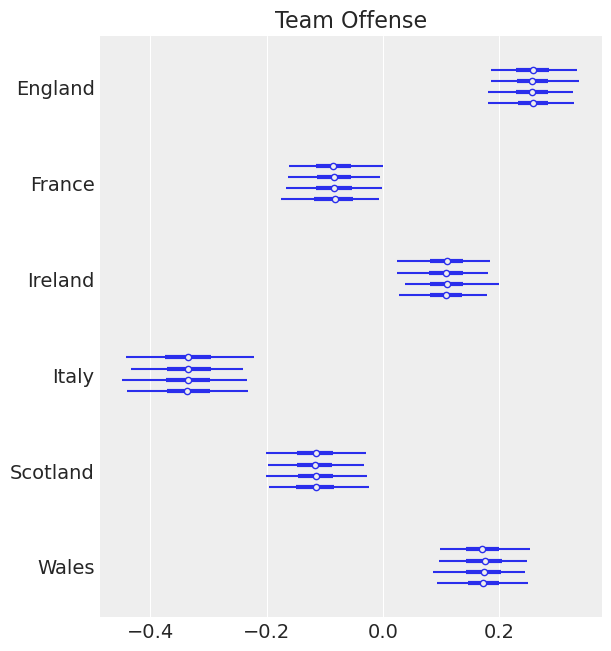

In [23]:
ax = az.plot_forest(trace, var_names=["atts"], labeller=TeamLabeller())
ax[0].set_title("Team Offense");

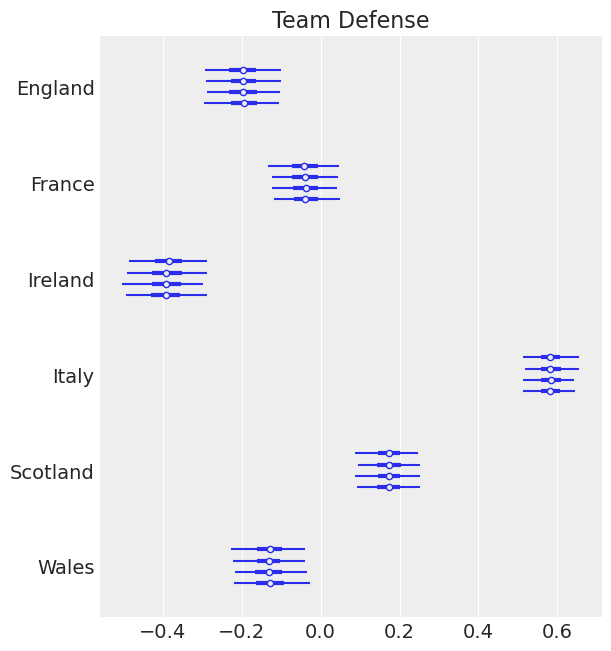

In [24]:
ax = az.plot_forest(trace, var_names=["defs"], labeller=TeamLabeller())
ax[0].set_title("Team Defense");

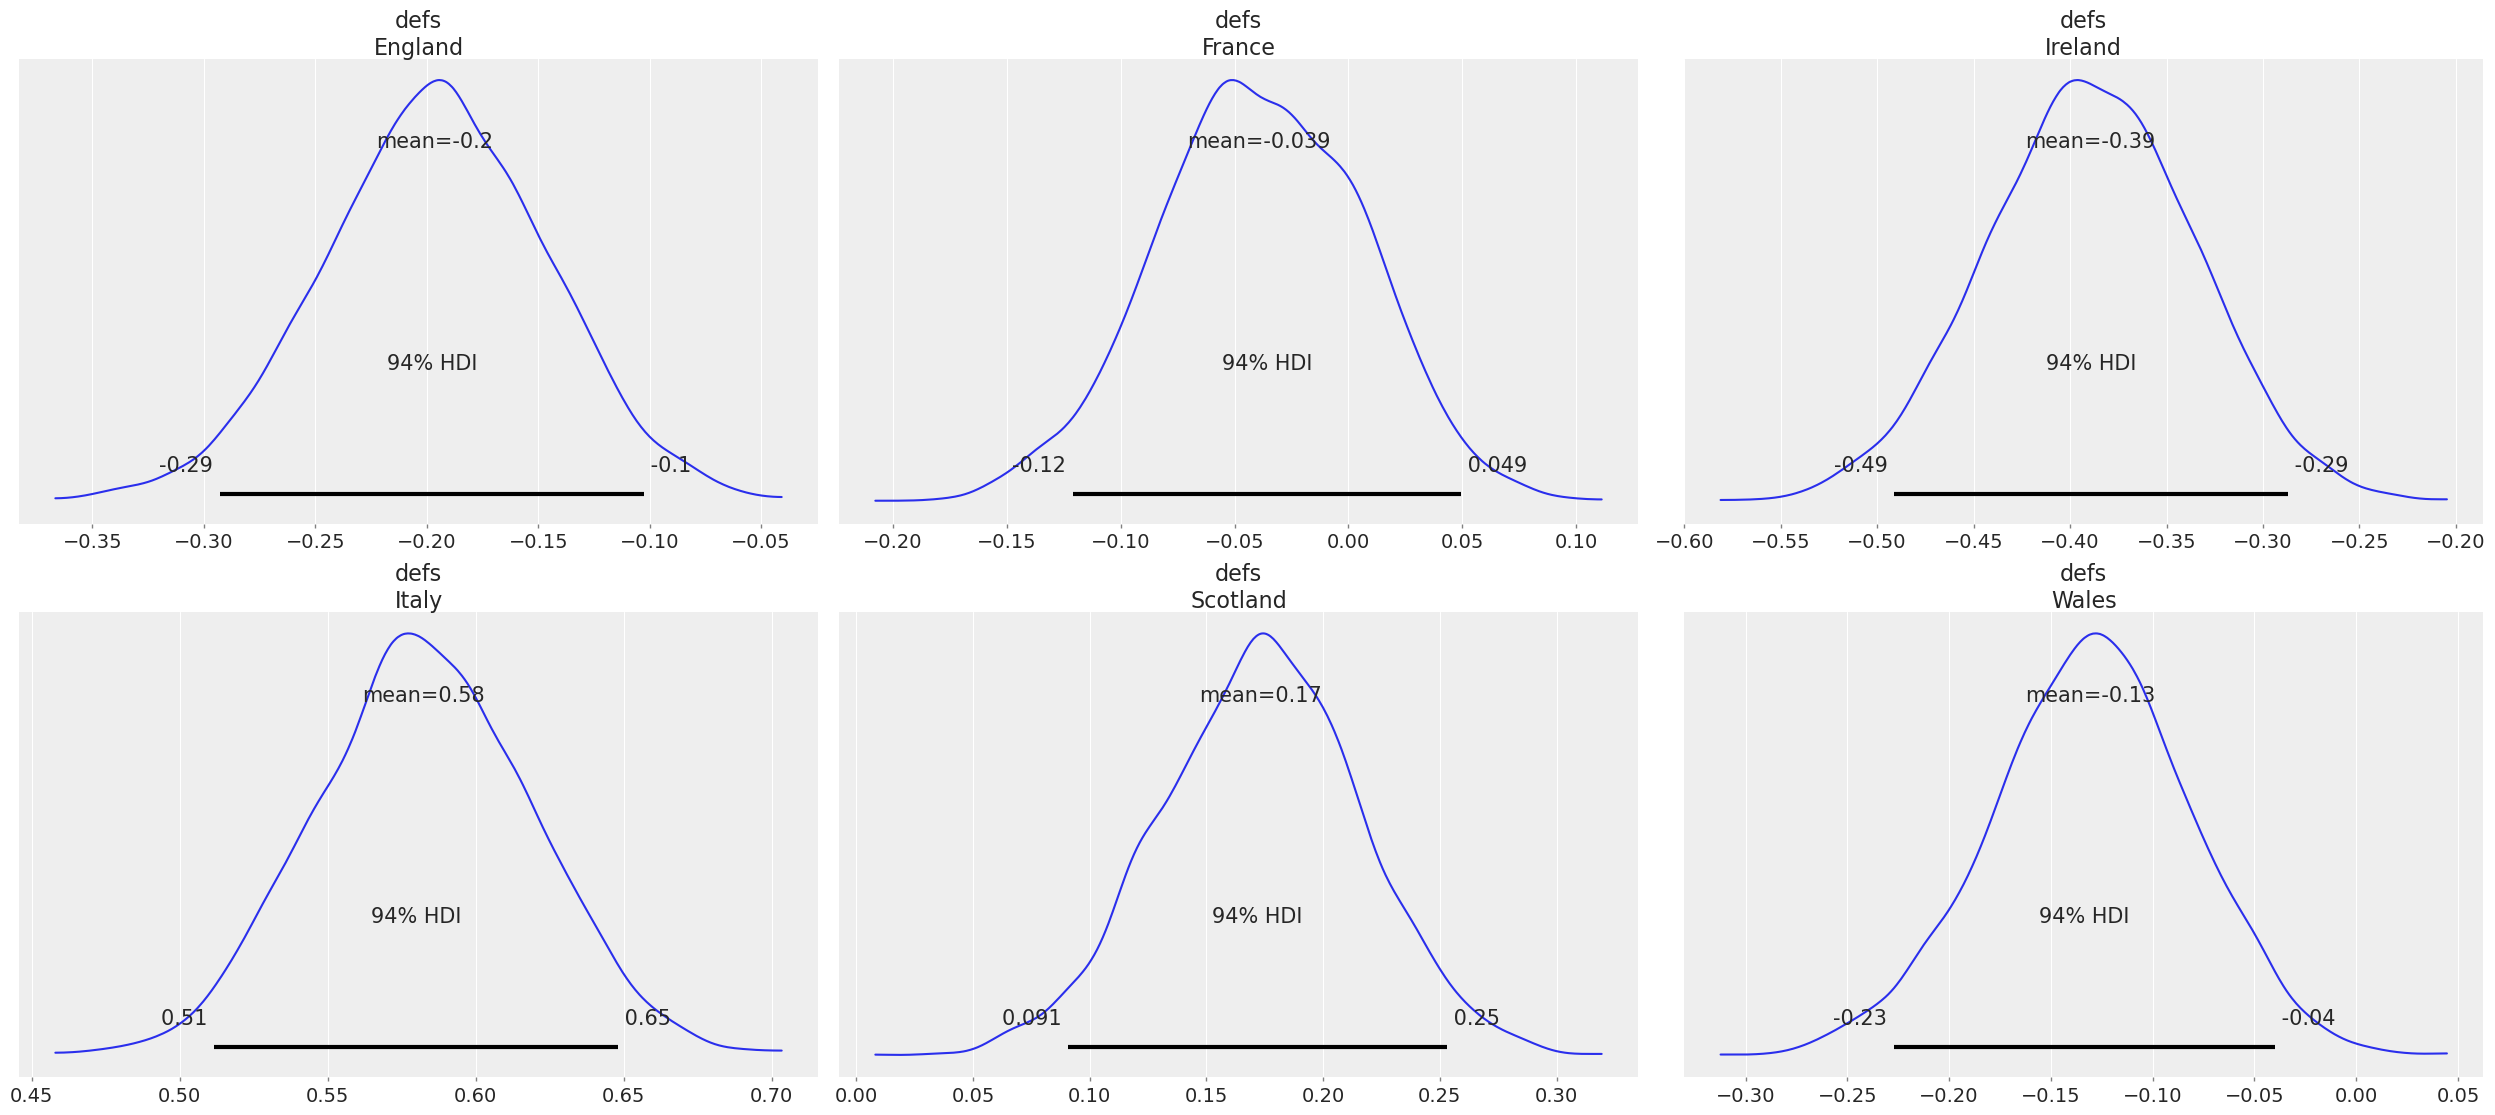

In [25]:
az.plot_posterior(trace, var_names=["defs"]);

In [17]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [10]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
pp = trace.posterior_predictive #observed vars or provided by `var_names`
const = trace.constant_data     #Data
team_da = trace.posterior.team  #Coordinates

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

In [18]:
pp

<xarray.Dataset> Size: 4MB
Dimensions:      (chain: 4, draw: 1000, match: 60)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * match        (match) int64 480B 0 1 2 3 4 5 6 7 ... 52 53 54 55 56 57 58 59
Data variables:
    away_points  (chain, draw, match) int64 2MB 24 20 12 9 23 ... 35 13 24 27 10
    home_points  (chain, draw, match) int64 2MB 44 15 28 12 20 ... 34 28 21 23
Attributes:
    created_at:                 2024-04-28T15:17:57.587605+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [19]:
# fmt: off
pp["home_win"] = (
    (pp["home_points"] > pp["away_points"]) * 3     # home team wins and gets 3 points
    + (pp["home_points"] == pp["away_points"]) * 2  # tie -> home team gets 2 points
)
pp["away_win"] = (
    (pp["home_points"] < pp["away_points"]) * 3
    + (pp["home_points"] == pp["away_points"]) * 2
)
# fmt: on

In [20]:
pp

<xarray.Dataset> Size: 8MB
Dimensions:      (chain: 4, draw: 1000, match: 60)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * match        (match) int64 480B 0 1 2 3 4 5 6 7 ... 52 53 54 55 56 57 58 59
Data variables:
    away_points  (chain, draw, match) int64 2MB 24 20 12 9 23 ... 35 13 24 27 10
    home_points  (chain, draw, match) int64 2MB 44 15 28 12 20 ... 34 28 21 23
    home_win     (chain, draw, match) int64 2MB 3 0 3 3 0 3 3 ... 3 3 0 3 3 0 3
    away_win     (chain, draw, match) int64 2MB 0 3 0 0 3 0 0 ... 0 0 3 0 0 3 0
Attributes:
    created_at:                 2024-04-28T15:17:57.587605+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [23]:
const.home_team

<xarray.DataArray 'home_team' (match: 60)> Size: 240B
array([5, 1, 2, 2, 4, 1, 5, 3, 0, 2, 4, 0, 3, 5, 1, 5, 3, 1, 0, 2, 4, 4,
       1, 2, 5, 0, 3, 3, 4, 0, 1, 4, 2, 1, 5, 3, 5, 3, 0, 2, 0, 4, 5, 2,
       1, 4, 0, 3, 3, 5, 1, 4, 2, 0, 5, 3, 0, 4, 1, 2], dtype=int32)
Coordinates:
  * match    (match) int64 480B 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59

In [25]:
groupby_sum_home

<xarray.DataArray 'home_win' (chain: 4, draw: 1000, team: 6)> Size: 192kB
array([[[30, 15, 27,  2,  6, 23],
        [27, 18, 27,  0,  9, 23],
        [27, 12, 21,  0, 11, 21],
        ...,
        [30, 12, 30,  0, 12, 18],
        [24, 15, 29,  0,  6, 30],
        [26, 20, 27,  2, 11, 26]],

       [[27, 12, 24,  0,  9, 24],
        [27, 18, 27,  0,  9, 18],
        [30, 12, 27,  3,  6, 23],
        ...,
        [27, 15, 24,  0, 11, 21],
        [30, 12, 15,  0, 12, 22],
        [24, 12, 29,  0,  6, 18]],

       [[30, 18, 30,  0, 13, 27],
        [26, 15, 30,  0,  6, 27],
        [21,  9, 24,  0,  6, 27],
        ...,
        [27, 21, 27,  0,  6, 17],
        [28, 17, 29,  0,  9, 24],
        [30, 12, 21,  0,  9, 24]],

       [[29, 12, 27,  0,  6, 30],
        [30, 17, 25,  0, 15, 27],
        [27, 12, 27,  2, 12, 29],
        ...,
        [27, 15, 29,  0,  9, 29],
        [27, 12, 30,  0,  6, 24],
        [30, 12, 27,  0,  6, 30]]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * team     (team) object 48B 'England' 'France' ... 'Scotland' 'Wales'

In [24]:
groupby_sum_home = pp.home_win.groupby(team_da[const.home_team]).sum()
groupby_sum_away = pp.away_win.groupby(team_da[const.away_team]).sum()

pp["teamscores"] = groupby_sum_home + groupby_sum_away

In [27]:
from xarray_einstats.stats import rankdata

pp["rank"] = rankdata(-pp["teamscores"], dims="team", method="min")
pp[["rank"]].sel(team="England")

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    team     <U7 28B 'England'
Data variables:
    rank     (chain, draw) int64 32kB 1 2 1 1 2 3 1 1 2 2 ... 1 2 2 2 1 2 3 2 1
Attributes:
    created_at:                 2024-04-28T15:17:57.587605+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [30]:
pp["rank"]

<xarray.DataArray 'rank' (chain: 4, draw: 1000, team: 6)> Size: 192kB
array([[[1, 4, 2, 6, 5, 3],
        [2, 4, 1, 6, 5, 3],
        [1, 4, 3, 6, 5, 2],
        ...,
        [1, 5, 2, 6, 4, 3],
        [3, 4, 1, 6, 5, 2],
        [2, 4, 1, 6, 5, 3]],

       [[1, 4, 2, 6, 5, 3],
        [1, 4, 2, 6, 5, 3],
        [1, 4, 2, 6, 5, 3],
        ...,
        [2, 4, 1, 6, 5, 3],
        [1, 4, 3, 6, 4, 2],
        [2, 4, 1, 6, 5, 3]],

       [[1, 4, 2, 6, 5, 2],
        [2, 4, 1, 6, 5, 2],
        [3, 4, 1, 6, 5, 1],
        ...,
        [2, 3, 1, 6, 5, 4],
        [1, 4, 1, 6, 5, 3],
        [1, 4, 3, 6, 5, 2]],

       [[2, 4, 2, 6, 5, 1],
        [1, 4, 2, 6, 5, 3],
        [3, 4, 1, 6, 5, 1],
        ...,
        [3, 4, 1, 6, 5, 2],
        [2, 4, 1, 6, 5, 2],
        [1, 4, 3, 6, 5, 2]]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * team     (team) object 48B 'England' 'France' ... 'Scotland' 'Wales'

In [31]:
from xarray_einstats.numba import histogram

bin_edges = np.arange(7) + 0.5
data_sim = (
    histogram(pp["rank"], dims=("chain", "draw"), bins=bin_edges, density=True)
    .rename({"bin": "rank"})
    .assign_coords(rank=np.arange(6) + 1)
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [32]:
idx_dim, col_dim = data_sim.dims
sim_table = pd.DataFrame(data_sim, index=data_sim[idx_dim], columns=data_sim[col_dim])

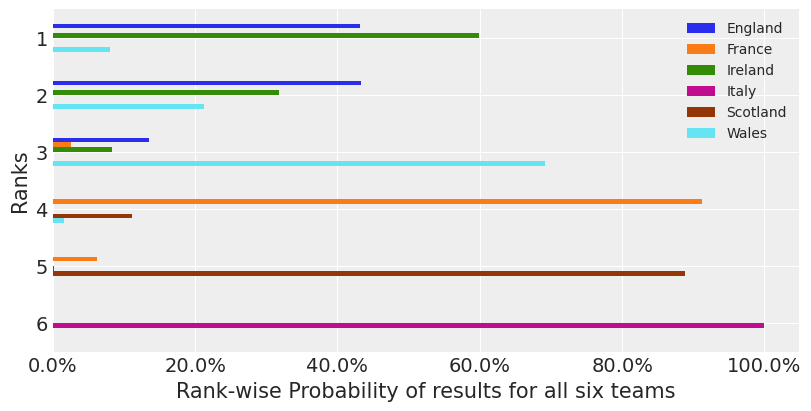

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sim_table.T.plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_xlabel("Rank-wise Probability of results for all six teams")
ax.set_yticklabels(np.arange(1, 7))
ax.set_ylabel("Ranks")
ax.invert_yaxis()
ax.legend(loc="best", fontsize="medium");

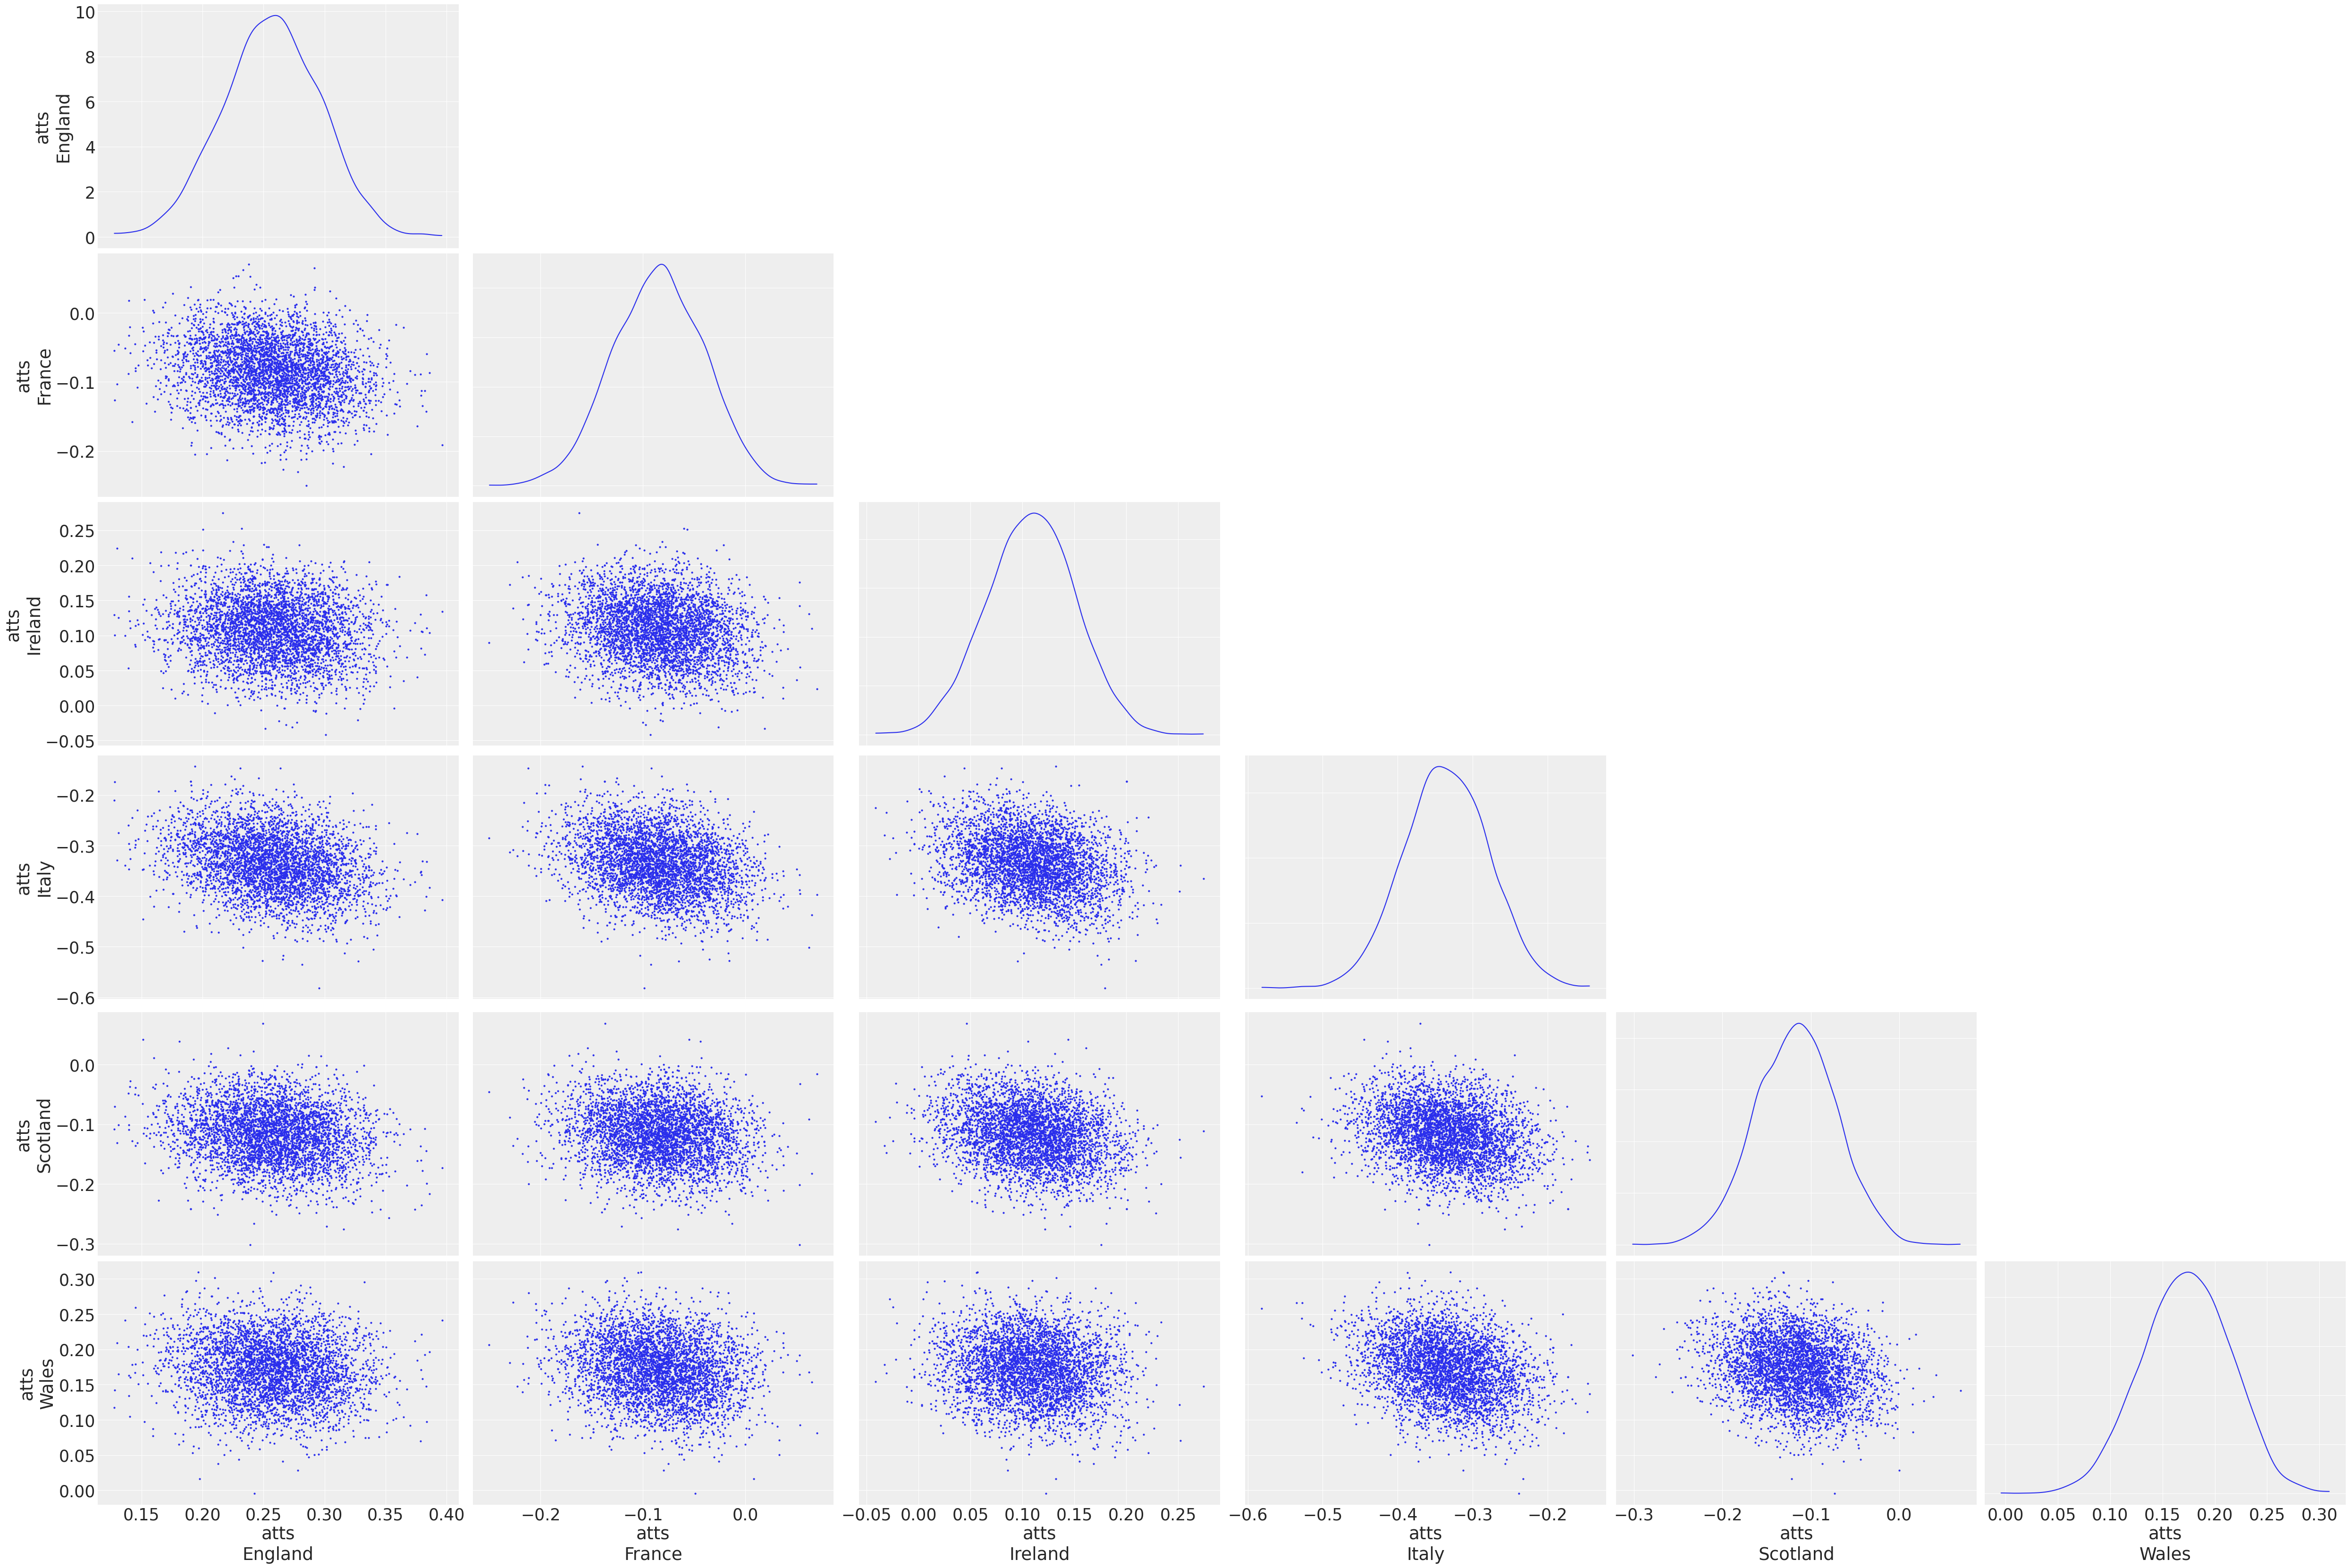

In [34]:
az.plot_pair(
    trace,
    var_names=["atts"],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
),
figsize = (10, 10)